In [2]:
import re
import os
import json
import pandas as pd
from rdkit import Chem
from transformers import AutoTokenizer
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit import RDLogger
from typing import List, Tuple, Dict
from rdkit import Chem
from rdkit.Chem import rdmolops, AllChem
rdBase.DisableLog('rdApp.error')
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.*')

def extract_solution(solution_str: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, solution_str))
    if matches:
        return matches[-1].group(1).strip()
    return None

response = """
Response 2: To generate the SMILES string for the given molecule, let's break down the provided description step by step:

1. **Starting with Steroid Backbone**: The molecule is based on a pregnane structure, which is a type of steroid. Pregnane typically has the structural formula of C21H36, forming four fused cyclohexane rings. 

2. **Specific Structure**: It has double bonds indicated as pregna-4,17-dien, meaning double bonds are present at the 4 position and 17 position. The steroid backbone must adjust to form these double bonds.

3. **Substitution and Ester Formation**: It is an ester, specifically methyl ester at the 21st position, indicating a methoxy carbonyl group (-COOCH3) attached to the C21 position.

4. **Oxo Substitutions**: The molecule has two oxo groups at the 3 position (3-oxo) and the 11 position (11-oxo). This suggests that carbonyl groups (=O) are attached to these positions within the steroid structure.

5. **Position Indication and Configuration**: The ester is in the form of (17E)-21-oate, which specifies the E (trans) configuration at the 17 position where the double bond is present.

With this breakdown, let's translate these structural elements into a SMILES format:

- **Steroid Backbone and Rings**: The basic cyclohexane rings for a steroid.
- **Double Bonds**: C=C indicating double bonds.
- **Carbonyl Group**: =O attached to the cyclohexane.
- **Ester Group**: -C(=O)OCH3.

Given these considerations, the SMILES string can be constructed as follows:

<answer> CC1CCC2C(C1)CCC3C2C(CC=C4C3(C(=O)CCC4=O)C)C(=O)OC </answer>
"""


/root/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from rdkit import Chem
from rdkit.Chem import Draw

gt = Chem.MolFromSmiles("CC([N+])[N+]([N+]N)C(c1nc(O)c[nH]n3[c@H](c(n1)c2c1)n3c(cc2ccc2N[C@H](O)[C@H](O))cn2)O")
Draw.MolToImage(gt)

[03:46:45] SMILES Parse Error: unclosed ring for input: 'CC([N+])[N+]([N+]N)C(c1nc(O)c[nH]n3[c@H](c(n1)c2c1)n3c(cc2ccc2N[C@H](O)[C@H](O))cn2)O'


ValueError: Null molecule provided

response_smi CC1CCC2C(C1)CCC3C2C(CC=C4C3(C(=O)CCC4=O)C)C(=O)OC


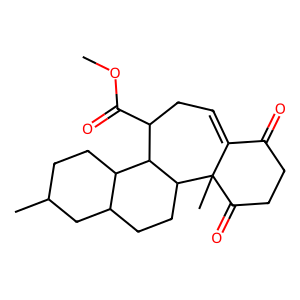

In [4]:
response_smi = extract_solution(response)
print('response_smi', response_smi )
response_mol = Chem.MolFromSmiles(response_smi)
Draw.MolToImage(response_mol)


In [8]:
from rdkit import Chem

pred = Chem.MolFromSmiles("CC1=CC=CC=C1")    # 甲基苯 = Toluene
gt   = Chem.MolFromSmiles("C1=CC=CC=C1")     # 苯 = Benzene

pred.HasSubstructMatch(gt)  # ✅ True：Toluene 包含 Benzene

True

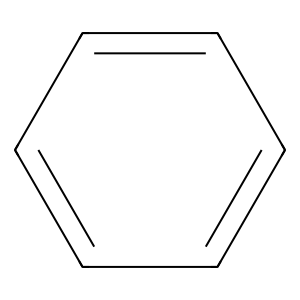

In [17]:
Draw.MolToImage(gt)


In [18]:
pred = Chem.MolFromSmiles("CCO")   # 乙醇
gt   = Chem.MolFromSmiles("CC=O")  # 乙醛

pred.HasSubstructMatch(gt)  # ❌ False：没有 CC=O 的官能团


False

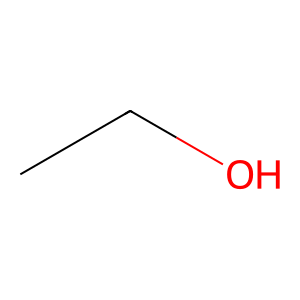

In [19]:
Draw.MolToImage(pred)


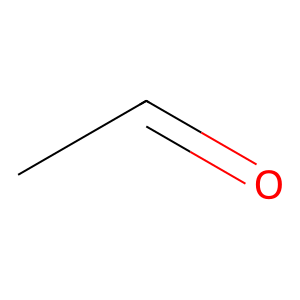

In [20]:
Draw.MolToImage(gt)


In [12]:
# Copyright 2024 Guojiang Zhao
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import re
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
from Levenshtein import distance as lev


def extract_solution(solution_str: str, method: str = "strict") -> str:
    """
    Extract the last <answer>...</answer> block from the solution string.
    """
    assert method in ["strict"], "Only 'strict' method is supported for SMILES extraction."
    matches = list(re.finditer(r"<answer>(.*?)</answer>", solution_str, re.DOTALL))
    return matches[-1].group(1).strip() if matches else None


def is_valid_smiles(smi: str) -> bool:
    return Chem.MolFromSmiles(smi) is not None


def exact_string_match(pred_smi: str, gt_smi: str) -> float:
    try:
        can_pred = Chem.MolToSmiles(Chem.MolFromSmiles(pred_smi))
        can_gt = Chem.MolToSmiles(Chem.MolFromSmiles(gt_smi))
        return 1.0 if can_pred == can_gt else 0.0
    except:
        return 0.0


def exact_structure_match(pred_smi: str, gt_smi: str) -> float:
    try:
        m1, m2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        return 1.0 if Chem.MolToInchi(m1) == Chem.MolToInchi(m2) else 0.0
    except:
        return 0.0


def substructure_match(pred_smi: str, gt_smi: str) -> float:
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        return 1.0 if mol1.HasSubstructMatch(mol2) else 0.0
    except:
        return 0.0


def property_similarity(pred_smi: str, gt_smi: str) -> float:
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        props1 = np.array([Descriptors.MolWt(mol1), Descriptors.MolLogP(mol1), Descriptors.TPSA(mol1)])
        props2 = np.array([Descriptors.MolWt(mol2), Descriptors.MolLogP(mol2), Descriptors.TPSA(mol2)])
        diff = np.abs(props1 - props2)
        return float(np.exp(-np.mean(diff) / 10))
    except:
        return 0.0


def fingerprint_similarity_scores(pred_smi: str, gt_smi: str):
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        maccs_sim = DataStructs.FingerprintSimilarity(MACCSkeys.GenMACCSKeys(mol1), MACCSkeys.GenMACCSKeys(mol2))
        rdk_sim = DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(mol1), Chem.RDKFingerprint(mol2))
        morgan_sim = DataStructs.TanimotoSimilarity(
            AllChem.GetMorganFingerprint(mol1, 2),
            AllChem.GetMorganFingerprint(mol2, 2)
        )
        return maccs_sim, rdk_sim, morgan_sim
    except:
        return 0.0, 0.0, 0.0


def smiles_levenshtein(pred_smi: str, gt_smi: str, normalize_len: int = 100) -> float:
    try:
        return 1.0 - lev(pred_smi, gt_smi) / normalize_len
    except:
        return 0.0


def compute_score(solution_str: str, ground_truth: str, method: str = "strict") -> dict:
    result = {
        "format_valid": 0.0,
        "exact_text_match": 0.0,
        "exact_struct_match": 0.0,
        "substructure_match": 0.0,
        "property_similarity": 0.0,
        "maccs_similarity": 0.0,
        "rdk_similarity": 0.0,
        "morgan_similarity": 0.0,
        "smiles_levenshtein": 0.0
    }

    pred_smi = extract_solution(solution_str, method=method)
    if pred_smi is None:
        return result

    result["format_valid"] = float(is_valid_smiles(pred_smi))
    result["exact_text_match"] = exact_string_match(pred_smi, ground_truth)
    result["exact_struct_match"] = exact_structure_match(pred_smi, ground_truth)
    result["substructure_match"] = substructure_match(pred_smi, ground_truth)
    result["property_similarity"] = property_similarity(pred_smi, ground_truth)
    result["maccs_similarity"], result["rdk_similarity"], result["morgan_similarity"] = fingerprint_similarity_scores(pred_smi, ground_truth)
    result["smiles_levenshtein"] = smiles_levenshtein(pred_smi, ground_truth)

    return result


In [13]:
compute_score(response, 'CCCCC[C@@H]1O[C@@H]1/C=C/C(O)C/C=C\\C/C=C\\CCCC(=O)[O-]')


{'format_valid': 1.0,
 'exact_text_match': 0.0,
 'exact_struct_match': 0.0,
 'substructure_match': 0.0,
 'property_similarity': 0.18544690456488067,
 'maccs_similarity': 0.43478260869565216,
 'rdk_similarity': 0.18309859154929578,
 'morgan_similarity': 0.043795620437956206,
 'smiles_levenshtein': 0.6799999999999999}

In [4]:
# Copyright 2024 Guojiang Zhao
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import re
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
from Levenshtein import distance as lev


def extract_solution(solution_str: str) -> str:
    """
    Extract the last <answer>...</answer> block from the solution string.
    """
    matches = list(re.finditer(r"<answer>(.*?)</answer>", solution_str, re.DOTALL))
    return matches[-1].group(1).strip() if matches else None


def is_valid_smiles(smi: str) -> bool:
    return Chem.MolFromSmiles(smi) is not None


def exact_string_match(pred_smi: str, gt_smi: str) -> float:
    try:
        can_pred = Chem.MolToSmiles(Chem.MolFromSmiles(pred_smi), canonical=True)
        can_gt = Chem.MolToSmiles(Chem.MolFromSmiles(gt_smi), canonical=True)
        return 1.0 if can_pred == can_gt else 0.0
    except:
        return 0.0


def exact_structure_match(pred_smi: str, gt_smi: str) -> float:
    try:
        m1, m2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        return 1.0 if Chem.MolToInchi(m1) == Chem.MolToInchi(m2) else 0.0
    except:
        return 0.0


def property_similarity(pred_smi: str, gt_smi: str) -> float:
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        props1 = np.array([Descriptors.MolWt(mol1), Descriptors.MolLogP(mol1), Descriptors.TPSA(mol1)])
        props2 = np.array([Descriptors.MolWt(mol2), Descriptors.MolLogP(mol2), Descriptors.TPSA(mol2)])
        diff = np.abs(props1 - props2)
        return float(np.exp(-np.mean(diff) / 10))
    except:
        return 0.0


def fingerprint_similarity_scores(pred_smi: str, gt_smi: str):
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        maccs_sim = DataStructs.FingerprintSimilarity(MACCSkeys.GenMACCSKeys(mol1), MACCSkeys.GenMACCSKeys(mol2))
        rdk_sim = DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(mol1), Chem.RDKFingerprint(mol2))
        morgan_sim = DataStructs.TanimotoSimilarity(
            AllChem.GetMorganFingerprint(mol1, 2),
            AllChem.GetMorganFingerprint(mol2, 2)
        )
        return maccs_sim, rdk_sim, morgan_sim
    except:
        return 0.0, 0.0, 0.0


def smiles_levenshtein(pred_smi: str, gt_smi: str, normalize_len: int = 100) -> float:
    try:
        return 1.0 - lev(pred_smi, gt_smi) / normalize_len
    except:
        return 0.0


def compute_score(solution_str: str, ground_truth: str) -> float:
    pred_smi = extract_solution(solution_str)
    if pred_smi is None:
        return 0.0  

    if not is_valid_smiles(pred_smi):
        return 0.0  

    
    exact_text = exact_string_match(pred_smi, ground_truth)
    exact_struct = exact_structure_match(pred_smi, ground_truth)
    prop_sim = property_similarity(pred_smi, ground_truth)
    maccs_sim, rdk_sim, morgan_sim = fingerprint_similarity_scores(pred_smi, ground_truth)
    lev_sim = smiles_levenshtein(pred_smi, ground_truth)

    weights = {
        "exact_text_match": 0.85, # 
        "exact_struct_match": 0.1,
        # "morgan_similarity": 0.15,
        # "property_similarity": 0.1,
        # "smiles_levenshtein": 0.05,
        # "rdk_similarity": 0.05,
        # "maccs_similarity": 0.05,
        "format_text": 0.05,
    }

    score = (
        weights["exact_text_match"] * exact_text +
        weights["exact_struct_match"] * exact_struct +
        # weights["property_similarity"] * prop_sim +
        # weights["morgan_similarity"] * morgan_sim +
        # weights["rdk_similarity"] * rdk_sim +
        # weights["maccs_similarity"] * maccs_sim +
        # weights["smiles_levenshtein"] * lev_sim + 
        weights["format_text"] * 1
    )

    return float(score)

In [6]:
compute_score(response, 'CCCCC[C@@H]1O[C@@H]1/C=C/C(O)C/C=C\\C/C=C\\CCCC(=O)[O-]')


0.05

In [5]:
# Copyright 2024 Guojiang Zhao
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import re
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
from Levenshtein import distance as lev
from rdkit import rdBase
from rdkit import RDLogger
from rdkit import Chem
rdBase.DisableLog('rdApp.error')
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.*')


def extract_solution(solution_str: str) -> str:
    """
    Extract the last <answer>...</answer> block from the solution string.
    """
    matches = list(re.finditer(r"<answer>(.*?)</answer>", solution_str, re.DOTALL))
    return matches[-1].group(1).strip() if matches else None


def is_valid_smiles(smi: str) -> bool:
    try:
        mol = Chem.MolFromSmiles(smi)
        return mol is not None
    except:
        return False


def exact_string_match(pred_smi: str, gt_smi: str) -> float:
    try:
        can_pred = Chem.MolToSmiles(Chem.MolFromSmiles(pred_smi), canonical=True)
        can_gt = Chem.MolToSmiles(Chem.MolFromSmiles(gt_smi), canonical=True)
        return 1.0 if can_pred == can_gt else 0.0
    except:
        return 0.0


def exact_structure_match(pred_smi: str, gt_smi: str) -> float:
    try:
        m1, m2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        return 1.0 if Chem.MolToInchi(m1) == Chem.MolToInchi(m2) else 0.0
    except:
        return 0.0


def property_similarity(pred_smi: str, gt_smi: str) -> float:
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        props1 = np.array([Descriptors.MolWt(mol1), Descriptors.MolLogP(mol1), Descriptors.TPSA(mol1)])
        props2 = np.array([Descriptors.MolWt(mol2), Descriptors.MolLogP(mol2), Descriptors.TPSA(mol2)])
        diff = np.abs(props1 - props2)
        return float(np.exp(-np.mean(diff) / 10))
    except:
        return 0.0


def fingerprint_similarity_scores(pred_smi: str, gt_smi: str):
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        maccs_sim = DataStructs.FingerprintSimilarity(MACCSkeys.GenMACCSKeys(mol1), MACCSkeys.GenMACCSKeys(mol2))
        rdk_sim = DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(mol1), Chem.RDKFingerprint(mol2))
        morgan_sim = DataStructs.TanimotoSimilarity(
            AllChem.GetMorganFingerprint(mol1, 2),
            AllChem.GetMorganFingerprint(mol2, 2)
        )
        return maccs_sim, rdk_sim, morgan_sim
    except:
        return 0.0, 0.0, 0.0


def smiles_levenshtein(pred_smi: str, gt_smi: str, normalize_len: int = 100) -> float:
    try:
        return 1.0 - lev(pred_smi, gt_smi) / normalize_len
    except:
        return 0.0


def compute_score(solution_str: str, ground_truth: str) -> float:
    
    pred_smi = extract_solution(solution_str)
    if pred_smi is None:
        return 0.0  

    if not is_valid_smiles(pred_smi):
        return 0.0  
    
    exact_text = exact_string_match(pred_smi, ground_truth)
    exact_struct = exact_structure_match(pred_smi, ground_truth)
    prop_sim = property_similarity(pred_smi, ground_truth)
    maccs_sim, rdk_sim, morgan_sim = fingerprint_similarity_scores(pred_smi, ground_truth)
    lev_sim = smiles_levenshtein(pred_smi, ground_truth)

    weights = {
        "exact_text_match": 0.5,         
        "exact_struct_match": 0.2,       
        "morgan_similarity": 0.15,       
        "property_similarity": 0.05,     
        "smiles_levenshtein": 0.05,      
        "rdk_similarity": 0.025,
        "maccs_similarity": 0.025,
        "format_text": 0.05,
    }

    score = (
        weights["exact_text_match"] * exact_text +
        weights["exact_struct_match"] * exact_struct +
        weights["property_similarity"] * prop_sim +
        weights["morgan_similarity"] * morgan_sim +
        weights["rdk_similarity"] * rdk_sim +
        weights["maccs_similarity"] * maccs_sim +
        weights["smiles_levenshtein"] * lev_sim + 
        weights["format_text"] * 1
    )
    
    return float(score)

In [6]:
compute_score(response, 'CCCCC[C@@H]1O[C@@H]1/C=C/C(O)C/C=C\\C/C=C\\CCCC(=O)[O-]')


0.11528871830006117

In [7]:
compute_score('[response] <answer>OC(C(C(C(CCCCC)O)O)O)C(O)C(C(C(C(CCCCC)O)O)O)O</answer>', 'CCCCC[C@@H]1O[C@@H]1/C=C/C(O)C/C=C\\C/C=C\\CCCC(=O)[O-]')


0.12349331277071675

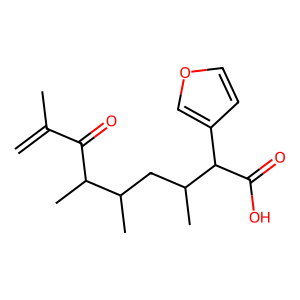

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw

gt = Chem.MolFromSmiles('C=C(C)C(=O)/C(C)C(C)CC(C)C(C(=O)O)c1ccoc1')
Draw.MolToImage(gt)

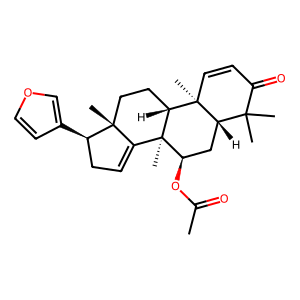

In [7]:
from rdkit import Chem
from rdkit.Chem import Draw

gt = Chem.MolFromSmiles('CC(=O)O[C@@H]1C[C@H]2C(C)(C)C(=O)C=C[C@]2(C)[C@H]2CC[C@]3(C)C(=CC[C@H]3c3ccoc3)[C@@]21C')
Draw.MolToImage(gt)

In [14]:
def compute_score(solution_str: str, ground_truth: str) -> float:
    pred_smi = extract_solution(solution_str)
    if pred_smi is None or not is_valid_smiles(pred_smi):
        return 0.0

    exact_text = exact_string_match(pred_smi, ground_truth)
    exact_struct = exact_structure_match(pred_smi, ground_truth)
    _, _, morgan_sim = fingerprint_similarity_scores(pred_smi, ground_truth)

    if exact_text == 1.0:
        return 1.0
    elif exact_struct == 1.0:
        return 0.9
    else:
        return 0.3 + 0.6 * morgan_sim  # 最低 0.3（鼓励），最高 0.9

In [15]:
compute_score(response, 'CCCCC[C@@H]1O[C@@H]1/C=C/C(O)C/C=C\\C/C=C\\CCCC(=O)[O-]')


0.3262773722627737

In [17]:
compute_score('<answer> C1CCCC(C(C(C(C(C1O)O)O)O)O)C(=O)OC(=O)O </answer>', 'CCCCC[C@@H]1O[C@@H]1/C=C/C(O)C/C=C\\C/C=C\\CCCC(=O)[O-]')


0.33076923076923076

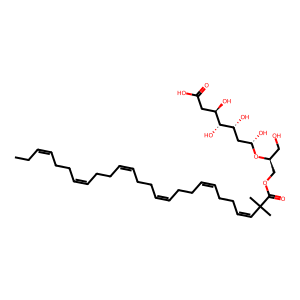

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw

test = Chem.MolFromSmiles('CC/C=C\\CC/C=C\\CC/C=C\\CC/C=C\\CC/C=C\\CC/C=C\\C(C)(C)C(=O)OC[C@H](CO)O[C@@H](O)C[C@@H](O)[C@H](O)[C@H](O)CC(=O)O')
Draw.MolToImage(test)

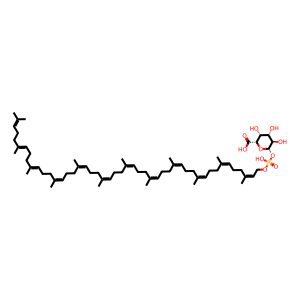

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw

gt = Chem.MolFromSmiles('CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\COP(=O)(O)O[C@@H]1O[C@H](C(=O)O)[C@H](O)[C@H](O)[C@H]1O')
Draw.MolToImage(gt)

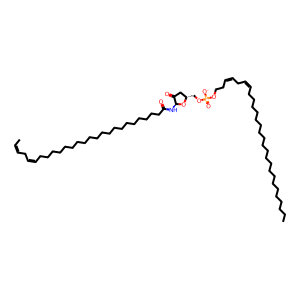

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw

test = Chem.MolFromSmiles('C/C=C\\C/C=C\\CCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H]1O[C@@H](COP(=O)([O-])OCC/C=C\\C/C=C\\CCCCCCCCCCCCCCCCCCCCC)CC1=O')
Draw.MolToImage(test)

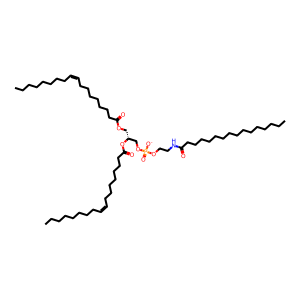

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw

gt = Chem.MolFromSmiles('CCCCCCCC/C=C\\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCCNC(=O)CCCCCCCCCCCCCCC)OC(=O)CCCCCCC/C=C\\CCCCCCCC')
Draw.MolToImage(gt)